# Start from CI_by_type function 

#### ORIE 4580/5580: Simulation
#### Fall 2020


Team NetIDs: cjl276, cjv47, gsp65, njc76, fw235, pjg222

In [141]:
#Import all necessary functions
import numpy as np
import pandas as pd
import scipy.stats as sc
import matplotlib.pyplot as plt
%matplotlib inline
#Animation
from IPython import display
import time
np.random.seed(6)

#### **Problem 2** (SIR epidemic on a clustered network) 

The SIR model can be made more
expressive by introducing more classes, and dividing the population into distinct classes, with
different inter-class and intra-class contact rates. You will now build such a model, which you
can then use in your project to test different vaccination strategies.

  - Agents belong to one of 4 base classes: C1 = medical workers, C2 = essential non-medical
workers, C3 = non-essential high-risk, and C4 = non-essential low-risk. Each class has
initial population n1, n2, n3, n4 respectively.
  - Agents in a class can be either susceptible, or infected but asymptomatic (thus each class
Ci has two sub-classes Si
, Ii); in addition, some agents become symptomatic, in which
case they migrate to a new class denoted Is. When an agent in class Ci becomes infected,
then she is symptomatic with probability pi
  - All infected agents recover and migrate to class R at a rate β.
  - Pairs of class i agents meet at a rate λi
, and a pair of class i and class j agents meet
at rate λij . For example, given ‘high rate’ h > ‘low rate’ l, we can use h as the rate for
meetings between agents from any class and agents in class C2, and also between agents
in class C1 (so λ1 = λ2 = λi2 = h ∀ i 6= 2), while all other rates are l.
In addition, agents in class Is only interact with essential medical workers in class C1 at
a rate λ1s (which also is typically high).

(Note: Here, you have to be careful in converting to average number of meetings per day,
as unlike the rate of meetings, this is now not symmetric; for example any grocery store
worker and any student may have the same rate of meetings, but the grocery store worker
meets many more students per day than the student meets grocery store workers.)

Build a simulator for this setting, and a way to visualize how the different clusters change
over time. Validate your model by testing extreme cases where you can compare with the earlier
model. In particular, set all pi = 0, and consider (1) single cluster (i.e., for any i, set ni = n and
nj = 0 ∀ j =6 i), and (2) a balanced network with ni = n/4 for all the four clusters, and all meeting
rates set equal.

In [396]:
import math
import numpy as np
import random

class State:
    def __init__(self, λ, λ_s, β, n, p, λ_v, n_v):
        #list of agents in classes C1, C2, C3, C4 respectively
        #medical workers
        self.medical_class = []
        #essential non-medical workers
        self.essential_nm = []
        #non-essential high-risk
        self.high_risk_ne = []
        #non-essential low-risk
        self.low_risk_ne = []
        #dictionary with each item containing a list of susceptible entities across classes
        self.S = {'C1': [], 'C2': [], 'C3': [], 'C4': []}
        #dictionary with each item containing a list of infected entities across classes
        self.I = {'C1': [], 'C2':[], 'C3': [], 'C4': []}
        #dictionary with each item containing a list of entities available for vaccination
        self.V = {'C1': [], 'C2': [], 'C3': [], 'C4': []}
        
        #Infected symptomatic across all classes
        self.I_sym = []
        #recovered across all classes
        self.R = []
        #Total agents infected
        self.infected = []
        #Total agents available for Vaccination
        self.V_tot = []
        
        #dict of probabilities an infected agent is symptomatic
        #{'C1': 0, 'C2': 0, 'C3', 0, 'C4': 0}
        self.p = p
        #dict of the size of each class
        #{'C1': 0, 'C2': 0, 'C3', 0, 'C4': 0}
        self.n = n
        #meet rate matrix
        self.λ = λ
        #sympotic meet rate with medical works
        self.λ_s = λ_s
        #recovery rate
        self.β = β
        #vaccination rate
        self.λ_v = λ_v
        #number of people in a group vaccinated for each arrival
        self.n_v = n_v
        
        #lists for recording data at events
        self.times = []
        self.num_inf = []
        self.C1_inf = []
        self.C2_inf = []
        self.C3_inf = []
        self.C4_inf = []
        self.int_time = [] 
        
        

class Agent:
    def __init__(self, c):
        """
        Arg(s): 
            c: string representation of this class type
        """
        #string representation of the state of the person ('S', 'I_a', 'I_s', 'R') 
        self.state = 'S'
        self.C = c
        

In [397]:
#Helper Functions for the Simulator
                          
def infect_entity(sim_state, key):
    """
    Helper function for the simulator that executes the process for 
    infecting a given class. NO return value, class variables are updated
    
    Arg(s):
        sim_state: An instance of class State
        key: String representation of the entitie's class
    """
    i = np.random.randint(0, len(sim_state.S[key]))
    ent = sim_state.S[key].pop(i)
    sim_state.infected.append(ent)
    #urv for if the patient shows symptoms or not
    prob = np.random.uniform()
    #patient is symptomatic
    if prob < sim_state.p[key]:
        ent.state = 'I_s'
        sim_state.I_sym.append(ent)
        sim_state.V[key].remove(ent)
        sim_state.V_tot.remove(ent)
    #patient is assymptomatic
    else:
        ent.state = 'I_a'
        sim_state.I[key].append(ent)

def calculate_rate(sim_state, key):
    """
    Calculates the rate of infection across a given class
    Arg(s):
        sim_state: an instance of class State
        key: String representation of the entitie's class
    Returns:
        Rates for C1, C2, C3, C4, β_tot (respectively)
    """
    ###Ways for C1 to get infected
    #number of (key,1) pairs
    n_pair_1 = len(sim_state.S[key]) * len(sim_state.I['C1'])
    #number of (key,2) pairs
    n_pair_2 = len(sim_state.S[key]) * len(sim_state.I['C2'])
    #number of (key,3) pairs
    n_pair_3 = len(sim_state.S[key]) * len(sim_state.I['C3'])
    #number of (key,4) pairs
    n_pair_4 = len(sim_state.S[key]) * len(sim_state.I['C4'])
    #number of pairs with C1 and symptomatic people
    n_pair_1a = len(sim_state.S['C1']) * len(sim_state.I_sym)

    #populating the rates according to the number of pairs of people
    n = int(key[1]) - 1
    #infection rate on key from class 1
    λ_1 = λ[n][0]
    #infection rate on key from class 2
    λ_2 = λ[n][1]
    #infection rate on key from class 3
    λ_3 = λ[n][2]
    #infection rate on key from class 4
    λ_4 = λ[n][3]
    λ_1a = λ_s 
    
    
    #rate that the class key is infected
    λ_key = λ_1 * n_pair_1 + λ_2 * n_pair_2 + λ_3 * n_pair_3 + λ_4 * n_pair_4 + (λ_1a * n_pair_1a * (key == 'C1'))

    return λ_key


In [100]:

def SIR_cluster_simulator(T,infect, λ, λ_s, β, n, p, λ_v, n_v):
    """
    Simulate an epidemic clustered by class
    
    Arg(s):
        Suggestion: 
        Priority_queue: ordered list of class types by vaccnination priortiy (if possible, the proportion of people in each class that need to be vaccinated)
        i.e. {"C1": 80% need to vaccinate before moving on, "C2": 50% need to vaccinate before moving on, etc.}
        poisson or not --> if yes, use SIR in 1 --> if no, use SIR_Onego (1part_e)
        
        T: Amount of time to simulate over
        infect: String input that is the class of the infected entity 
        λ: meet rate 2x2 matrix 
        λ_s: meet rate for symptomatic and C1
        beta: recovery rate
        n: dict of the size of each class
        p: dict of probabilities an infected agent is symptomatic
        λ_v: rate a vaccination event happens
        n_v: the number of people in a group that are vaccinated during a vaccination event (default is one)
        
    """
    #initializing the state of the system based on the inputs
    sim_state = State(λ, λ_s, β, n, p, λ_v, n_v)
    
    for key, value in n.items():
        for i in range(n[key]):
            agent = Agent(key)
            sim_state.S[key].append(agent)
            sim_state.V[key].append(agent)
            sim_state.V_tot.append(agent)
            if key == 'C1':
                sim_state.medical_class.append(agent)
            elif key == 'C2':
                sim_state.essential_nm.append(agent)
            elif key == 'C3':
                sim_state.high_risk_ne.append(agent)
            else:
                sim_state.low_risk_ne.append(agent)
    
    #infecting a single person of classs 'infect'
    ent = sim_state.S[infect].pop(0)
    ent.state = 'I_a'
    sim_state.I[infect].append(ent)
    sim_state.infected.append(ent)

    count = 0
    while count < T:
        #retrieving rate values across classes
        λ_C1 = calculate_rate(sim_state, 'C1')
        λ_C2 = calculate_rate(sim_state, 'C2')
        λ_C3 = calculate_rate(sim_state, 'C3')
        λ_C4 = calculate_rate(sim_state, 'C4')
        #total recovery rate
        β_tot = β * (len(sim_state.I['C1']) + len(sim_state.I_sym) + len(sim_state.I['C2']) + \
                                         len(sim_state.I['C3']) + len(sim_state.I['C4']))
        #total vaccination rate
        if len(sim_state.V_tot) > 0:
            λv_tot = (λ_v/ n_v)
        else:
            λv_tot = 0
        
        λ_tot = λ_C1 + λ_C2 + λ_C3 + λ_C4 + β_tot + λv_tot
        
        #case if virus is erradicated
        if λ_tot == 0:
            break

        λ_rand = np.random.exponential(1/λ_tot)
        count += λ_rand
        U = np.random.uniform()
        
        ###CASE 1: A susceptible person from C1 is infected
        if U < λ_C1 / λ_tot:
            infect_entity(sim_state, 'C1')
            
        ###CASE 2: A susceptible person from C2 is infected
        elif U < (λ_C1 + λ_C2) / λ_tot:
            infect_entity(sim_state, 'C2')
        
        ###CASE 3: A susceptible person from C3 is infected
        elif U < (λ_C1 + λ_C2 +λ_C3) / λ_tot:
            infect_entity(sim_state, 'C3')

        ###CASE 4: A susceptible person from C4 is infected
        elif U < (λ_C1 + λ_C2 +λ_C3+ λ_C4) / λ_tot:
            infect_entity(sim_state, 'C4')
            
        ###Case 5: An entity (or batch) is vaccinated
        elif U < (λ_C1 + λ_C2 + λ_C3 + λ_C4 + λv_tot) / λ_tot:
            #all people available for vaccination
            n = min(n_v, len(sim_state.V_tot))
            for i in range(n):
                i = np.random.randint(0, len(sim_state.V_tot))
                ent = sim_state.V_tot.pop(i)
                sim_state.V[ent.C].remove(ent)
                if ent in sim_state.S[ent.C]:
                    sim_state.S[ent.C].remove(ent)
                    ent.state = "R_v"
                else:
                    sim_state.I[ent.C].remove(ent)
                    sim_state.infected.remove(ent)
                    ent.state = 'R'
                sim_state.R.append(ent)
                
                     
        ###Case 6: A person recovers
        else:
            i = np.random.randint(0, len(sim_state.infected))
            ent = sim_state.infected.pop(i)
            sim_state.R.append(ent)
            #if the recovered person is from assymptomatic
            if ent.state == 'I_a':
                sim_state.I[ent.C].remove(ent)
                sim_state.V[ent.C].remove(ent)
                sim_state.V_tot.remove(ent)
            #if the recovered person is symptomatic
            else:
                sim_state.I_sym.remove(ent)
            ent.state = 'R'

        #recording data
        sim_state.times.append(count)
        sim_state.num_inf.append(len(sim_state.infected))
        #counting infected showing symptoms for all classes
        C1 = sim_state.n['C1'] - (len(sim_state.S['C1']))
        C2 = sim_state.n['C2'] - (len(sim_state.S['C2']))
        C3 = sim_state.n['C3'] - (len(sim_state.S['C3']))
        C4 = sim_state.n['C4'] - (len(sim_state.S['C4']))
        
        for ent in sim_state.R:
            if ent.C == 'C1':
                C1 -= 1
            elif ent.C == 'C2':
                C2 -= 1
            elif ent.C == 'C3':
                C3 -= 1
            else:
                C4 -= 1
        
        sim_state.C1_inf.append(C1)
        sim_state.C2_inf.append(C2)
        sim_state.C3_inf.append(C3)
        sim_state.C4_inf.append(C4)
    
    return sim_state


In [101]:
# import matplotlib.pyplot as plt


# #Time period to simulate over
# T = 1000000000
# #high meeting rate
# h = 0.5
# #low meeting rate
# l = 0.1
# #rate matrix of 4 classes (must be symmetric)
# λ = [[h,h,l,l],[h,h,h,h],[l,h,l,l], [l,h,l,l]]
# #meet rate symptomatic entities have with C1 (medical) 
# λ_s = 1
# #rate of recovery 
# β = 8
# #Number of entities in each class 
# n = {'C1': 70, 'C2': 50 , 'C3': 100, 'C4': 400}
# #probability an entity becomes symptomatic when infected
# p = {'C1': 0.5, 'C2': 0.5, 'C3': 0.5, 'C4': 0.5}
# #vaccination rate
# λ_v = 500
# #vaccination batch size
# n_v = 50

# sim = SIR_cluster_simulator(T,'C2', λ, λ_s, β, n, p, λ_v, n_v = n_v)

# #list of event times
# t = sim.times
# #list of total infected at each event time
# inf_tot = sim.num_inf
# #list of infection over time for all Classes
# C1 = sim.C1_inf
# C2 = sim.C2_inf
# C3 = sim.C3_inf
# C4 = sim.C4_inf

# #Total Number of Entities that got sick 
# vac = 0
# class_inf = {'C1': 0, 'C2': 0, 'C3': 0, 'C4': 0}
# for ent in sim.R:
#     if ent.state == 'R_v':
#         vac -= 1
#     else:
#         class_inf[ent.C] += 1
        

# print('Total Amount of entities that got infected across simulation: ', len(sim.R) + vac)
# print('Amount of C1 entities that got infected across simulation: ', class_inf['C1'])
# print('Amount of C2 entities that got infected across simulation: ', class_inf['C2'])
# print('Amount of C3 entities that got infected across simulation: ', class_inf['C3'])
# print('Amount of C4 entities that got infected across simulation: ', class_inf['C4'])

# plt.plot(t, inf_tot)

In [102]:
# fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(16, 10))
# # plot with various axes scales
# plt.figure()

# # C1
# ax[0][0].plot(t, C1)
# ax[0][0].set_title('C1: Medical Workers')
# ax[0][0].set_xlabel('Event Times')
# ax[0][0].set_ylabel('Infection Count')

# # C2
# ax[0][1].plot(t, C2)
# ax[0][1].set_title('C2: Essential Non Medical')
# ax[0][1].set_xlabel('Event Times')
# ax[0][1].set_ylabel('Infection Count')

# # C3
# ax[1][0].plot(t, C3)
# ax[1][0].set_title('C3: Non-Essential High Risk')
# ax[1][0].set_xlabel('Event Times')
# ax[1][0].set_ylabel('Infection Count')

# # C4
# ax[1][1].plot(t, C4)
# ax[1][1].set_title('C4: Non-Essential Low Risk')
# ax[1][1].set_xlabel('Event Times')
# ax[1][1].set_ylabel('Infection Count')

# plt.show()

In [401]:
def CI_by_type(rate, batch_size, trials):
    #Time period to simulate over
    T = 1000000000
    #high meeting rate
    h = 1.32
    #low meeting rate
    l = 0.32
    #rate matrix of 4 classes (must be symmetric)
    λ = [[h,h,l,l],[h,h,h,h],[l,h,l, l], [l,h,l,l]]
    #meet rate symptomatic entities have with C1 (medical) 
    λ_s = 1
    #rate of recovery 
    β = 3.64
    #Number of entities in each class 
    n = {'C1': 16, 'C2': 16 , 'C3': 16, 'C4': 275}
    #probability an entity becomes symptomatic when infected
    p = {'C1': 0.8, 'C2': 0.65, 'C3': 0.65, 'C4': 0.60}
    #vaccination rate
    λ_v = rate
    #vaccination batch size
    n_v = batch_size
    
    total_pop = []
    C1_pop = []
    C2_pop = []
    C3_pop = []
    C4_pop = []
    
    
    for i in range(trials):
        sim = SIR_cluster_simulator(T,'C2', λ, λ_s, β, n, p, λ_v, n_v = n_v)

        #list of event times
        t = sim.times
        #list of total infected at each event time
        inf_tot = sim.num_inf
        #list of infection over time for all Classes
        C1 = sim.C1_inf
        C2 = sim.C2_inf
        C3 = sim.C3_inf
        C4 = sim.C4_inf

        #Total Number of Entities that got sick 
        vac = 0
        class_inf = {'C1': 0, 'C2': 0, 'C3': 0, 'C4': 0}
        for ent in sim.R:
            if ent.state == 'R_v':
                vac -= 1
            else:
                class_inf[ent.C] += 1
                
        total_pop.append(len(sim.R) + vac)
        C1_pop.append(class_inf['C1'])
        C2_pop.append(class_inf['C2'])
        C3_pop.append(class_inf['C3'])
        C4_pop.append(class_inf['C4'])
        
    total_av = np.mean(total_pop)
    C1_av = np.mean(C1_pop)
    C2_av = np.mean(C2_pop)
    C3_av = np.mean(C3_pop)
    C4_av = np.mean(C4_pop)
    
    total_ci = (1.96*np.std(total_pop))/np.sqrt(len(total_pop))
    C1_ci = (1.96*np.std(C1_pop))/np.sqrt(len(C1_pop))
    C2_ci = (1.96*np.std(C2_pop))/np.sqrt(len(C2_pop))
    C3_ci = (1.96*np.std(C3_pop))/np.sqrt(len(C3_pop))
    C4_ci = (1.96*np.std(C4_pop))/np.sqrt(len(C4_pop))
    
#     use this version if you want the value for each key to be the C.I. (lower_bound, upper_bound)
#     outputs = {
#         total_av: (total_av - total_ci, total_av + total_ci), 
#         C1_av: (C1_av - C1_ci, C1_av + C1_ci), 
#         C2_av: (C2_av - C2_ci, C2_av + C2_ci), 
#         C3_av: (C3_av - C3_ci, C3_av + C3_ci), 
#         C4_av: (C4_av - C4_ci, C4_av + C4_ci), 
#     }
    
#this version has the value for each key being the CI half-length  
    outputs = {
        total_av: total_ci, 
        C1_av: C1_ci, 
        C2_av: C2_ci, 
        C3_av: C3_ci,  
        C4_av: C4_ci,  
    }
    return outputs 

In [410]:
total_average_infected = []
C1_average_infected = []
C2_average_infected = []
C3_average_infected = []
C4_average_infected = []

total_average_infected_ci = []
C1_average_infected_ci = []
C2_average_infected_ci = []
C3_average_infected_ci = []
C4_average_infected_ci = []


for i in range(100,10000,100):
    obj = CI_by_type(i,50,100)
    total_average_infected.append(list(obj.keys())[0]) 
    C1_average_infected.append(list(obj.keys())[1])
    C2_average_infected.append(list(obj.keys())[2])
    C3_average_infected.append(list(obj.keys())[3])
    C4_average_infected.append(list(obj.keys())[4])
    
    total_average_infected_ci.append(obj[list(obj.keys())[0]]) 
    C1_average_infected_ci.append(obj[list(obj.keys())[1]])
    C2_average_infected_ci.append(obj[list(obj.keys())[2]])
    C3_average_infected_ci.append(obj[list(obj.keys())[3]])
    C4_average_infected_ci.append(obj[list(obj.keys())[4]])
    

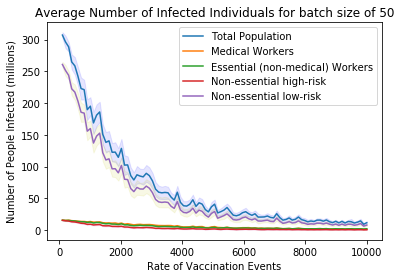

In [437]:
##Shaded area represents confidence interals 
x = np.linspace(100,10000,99)
fig, ax = plt.subplots()
y = np.asarray(total_average_infected)
y1 = np.asarray(C1_average_infected)
y2 = np.asarray(C2_average_infected)
y3 = np.asarray(C3_average_infected)
y4 = np.asarray(C4_average_infected)


ax.plot(x,y, label = "Total Population")
ax.fill_between(x, (y-total_average_infected_ci), 
                (y+total_average_infected_ci), color = 'b', alpha=.1)

ax.plot(x,y1, label = "Medical Workers")
ax.fill_between(x, (y1-C1_average_infected_ci), 
                (y1+C1_average_infected_ci), color = 'r', alpha=.1)

ax.plot(x,y2, label = "Essential (non-medical) Workers")
ax.fill_between(x, (y2-C2_average_infected_ci), 
                (y2+C2_average_infected_ci), color = 'g', alpha=.1)

ax.plot(x,y3, label = "Non-essential high-risk")
ax.fill_between(x, (y3-C3_average_infected_ci), 
                (y3+C3_average_infected_ci), color = 'm', alpha=.1)

ax.plot(x,y4, label = "Non-essential low-risk")
ax.fill_between(x, (y4-C4_average_infected_ci), 
                (y4+C4_average_infected_ci), color = 'y', alpha=.1)

plt.legend()
plt.title("Average Number of Infected Individuals for batch size of 50")
plt.xlabel("Rate of Vaccination Events")
plt.ylabel("Number of People Infected (millions)")
plt.show()

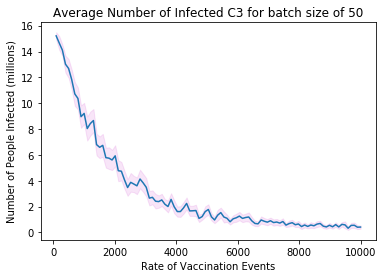

In [438]:
fig, ax = plt.subplots()
ax.plot(x,y3, label = "Non-essential high-risk")
ax.fill_between(x, (y3-C3_average_infected_ci), 
                (y3+C3_average_infected_ci), color = 'm', alpha=.1)

plt.title("Average Number of Infected C3 for batch size of 50")
plt.xlabel("Rate of Vaccination Events")
plt.ylabel("Number of People Infected (millions)")
plt.show()

In [439]:
total_average_infected = []
C1_average_infected = []
C2_average_infected = []
C3_average_infected = []
C4_average_infected = []

total_average_infected_ci = []
C1_average_infected_ci = []
C2_average_infected_ci = []
C3_average_infected_ci = []
C4_average_infected_ci = []


for i in range(1,1000,10):
    obj = CI_by_type(5700,i,100)
    total_average_infected.append(list(obj.keys())[0]) 
    C1_average_infected.append(list(obj.keys())[1])
    C2_average_infected.append(list(obj.keys())[2])
    C3_average_infected.append(list(obj.keys())[3])
    C4_average_infected.append(list(obj.keys())[4])
    
    total_average_infected_ci.append(obj[list(obj.keys())[0]]) 
    C1_average_infected_ci.append(obj[list(obj.keys())[1]])
    C2_average_infected_ci.append(obj[list(obj.keys())[2]])
    C3_average_infected_ci.append(obj[list(obj.keys())[3]])
    C4_average_infected_ci.append(obj[list(obj.keys())[4]])
    

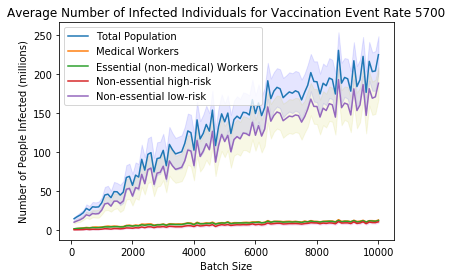

In [442]:
##Shaded area represents confidence interals 
x = np.linspace(100,10000,100)
fig, ax = plt.subplots()
y = np.asarray(total_average_infected)
y1 = np.asarray(C1_average_infected)
y2 = np.asarray(C2_average_infected)
y3 = np.asarray(C3_average_infected)
y4 = np.asarray(C4_average_infected)


ax.plot(x,y, label = "Total Population")
ax.fill_between(x, (y-total_average_infected_ci), 
                (y+total_average_infected_ci), color = 'b', alpha=.1)

ax.plot(x,y1, label = "Medical Workers")
ax.fill_between(x, (y1-C1_average_infected_ci), 
                (y1+C1_average_infected_ci), color = 'r', alpha=.1)

ax.plot(x,y2, label = "Essential (non-medical) Workers")
ax.fill_between(x, (y2-C2_average_infected_ci), 
                (y2+C2_average_infected_ci), color = 'g', alpha=.1)

ax.plot(x,y3, label = "Non-essential high-risk")
ax.fill_between(x, (y3-C3_average_infected_ci), 
                (y3+C3_average_infected_ci), color = 'm', alpha=.1)

ax.plot(x,y4, label = "Non-essential low-risk")
ax.fill_between(x, (y4-C4_average_infected_ci), 
                (y4+C4_average_infected_ci), color = 'y', alpha=.1)

plt.legend()
plt.title("Average Number of Infected Individuals for Vaccination Event Rate 5700")
plt.xlabel("Batch Size")
plt.ylabel("Number of People Infected (millions)")
plt.show()

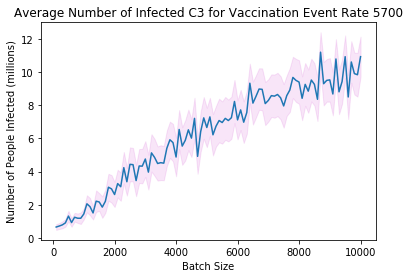

In [443]:
fig, ax = plt.subplots()
ax.plot(x,y3, label = "Non-essential high-risk")
ax.fill_between(x, (y3-C3_average_infected_ci), 
                (y3+C3_average_infected_ci), color = 'm', alpha=.1)

plt.title("Average Number of Infected C3 for Vaccination Event Rate 5700")
plt.xlabel("Batch Size")
plt.ylabel("Number of People Infected (millions)")
plt.show()

In [444]:
total_average_infected = []
C1_average_infected = []
C2_average_infected = []
C3_average_infected = []
C4_average_infected = []

total_average_infected_ci = []
C1_average_infected_ci = []
C2_average_infected_ci = []
C3_average_infected_ci = []
C4_average_infected_ci = []


for i in range(100,10000,100):
    obj = CI_by_type(i,1,100)
    total_average_infected.append(list(obj.keys())[0]) 
    C1_average_infected.append(list(obj.keys())[1])
    C2_average_infected.append(list(obj.keys())[2])
    C3_average_infected.append(list(obj.keys())[3])
    C4_average_infected.append(list(obj.keys())[4])
    
    total_average_infected_ci.append(obj[list(obj.keys())[0]]) 
    C1_average_infected_ci.append(obj[list(obj.keys())[1]])
    C2_average_infected_ci.append(obj[list(obj.keys())[2]])
    C3_average_infected_ci.append(obj[list(obj.keys())[3]])
    C4_average_infected_ci.append(obj[list(obj.keys())[4]])

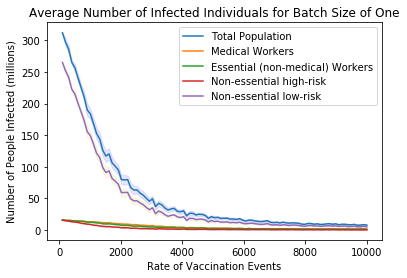

In [445]:
##Shaded area represents confidence interals 
x = np.linspace(100,10000,99)
fig, ax = plt.subplots()
y = np.asarray(total_average_infected)
y1 = np.asarray(C1_average_infected)
y2 = np.asarray(C2_average_infected)
y3 = np.asarray(C3_average_infected)
y4 = np.asarray(C4_average_infected)


ax.plot(x,y, label = "Total Population")
ax.fill_between(x, (y-total_average_infected_ci), 
                (y+total_average_infected_ci), color = 'b', alpha=.1)

ax.plot(x,y1, label = "Medical Workers")
ax.fill_between(x, (y1-C1_average_infected_ci), 
                (y1+C1_average_infected_ci), color = 'r', alpha=.1)

ax.plot(x,y2, label = "Essential (non-medical) Workers")
ax.fill_between(x, (y2-C2_average_infected_ci), 
                (y2+C2_average_infected_ci), color = 'g', alpha=.1)

ax.plot(x,y3, label = "Non-essential high-risk")
ax.fill_between(x, (y3-C3_average_infected_ci), 
                (y3+C3_average_infected_ci), color = 'm', alpha=.1)

ax.plot(x,y4, label = "Non-essential low-risk")
ax.fill_between(x, (y4-C4_average_infected_ci), 
                (y4+C4_average_infected_ci), color = 'y', alpha=.1)

plt.legend()
plt.title("Average Number of Infected Individuals for Batch Size of One")
plt.xlabel("Rate of Vaccination Events")
plt.ylabel("Number of People Infected (millions)")
plt.show()

Total Amount of entities that got infected across simulation:  38
Amount of C1 entities that got infected across simulation:  4
Amount of C2 entities that got infected across simulation:  5
Amount of C3 entities that got infected across simulation:  1
Amount of C4 entities that got infected across simulation:  28


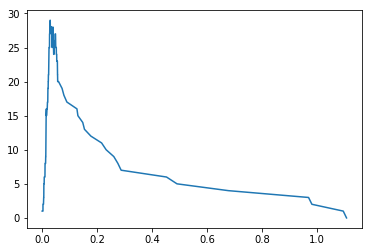

In [446]:
import matplotlib.pyplot as plt


#Time period to simulate over
T = 1000000000
#high meeting rate
h = 1.32
#low meeting rate
l = 0.32
#rate matrix of 4 classes (must be symmetric)
λ = [[h,h,l,l],[h,h,h,h],[l,h,l, l], [l,h,l,l]]
#meet rate symptomatic entities have with C1 (medical) 
λ_s = 1
#rate of recovery 
β = 3.64
#Number of entities in each class 
n = {'C1': 16, 'C2': 16 , 'C3': 16, 'C4': 275}
#probability an entity becomes symptomatic when infected
p = {'C1': 0.8, 'C2': 0.65, 'C3': 0.65, 'C4': 0.60}
#vaccination rate
λ_v = 4400
#vaccination batch size
n_v = 1

sim = SIR_cluster_simulator(T,'C2', λ, λ_s, β, n, p, λ_v, n_v = n_v)

#list of event times
t = sim.times
#list of total infected at each event time
inf_tot = sim.num_inf
#list of infection over time for all Classes
C1 = sim.C1_inf
C2 = sim.C2_inf
C3 = sim.C3_inf
C4 = sim.C4_inf

#Total Number of Entities that got sick 
vac = 0
class_inf = {'C1': 0, 'C2': 0, 'C3': 0, 'C4': 0}
for ent in sim.R:
    if ent.state == 'R_v':
        vac -= 1
    else:
        class_inf[ent.C] += 1
        

print('Total Amount of entities that got infected across simulation: ', len(sim.R) + vac)
print('Amount of C1 entities that got infected across simulation: ', class_inf['C1'])
print('Amount of C2 entities that got infected across simulation: ', class_inf['C2'])
print('Amount of C3 entities that got infected across simulation: ', class_inf['C3'])
print('Amount of C4 entities that got infected across simulation: ', class_inf['C4'])

plt.plot(t, inf_tot)

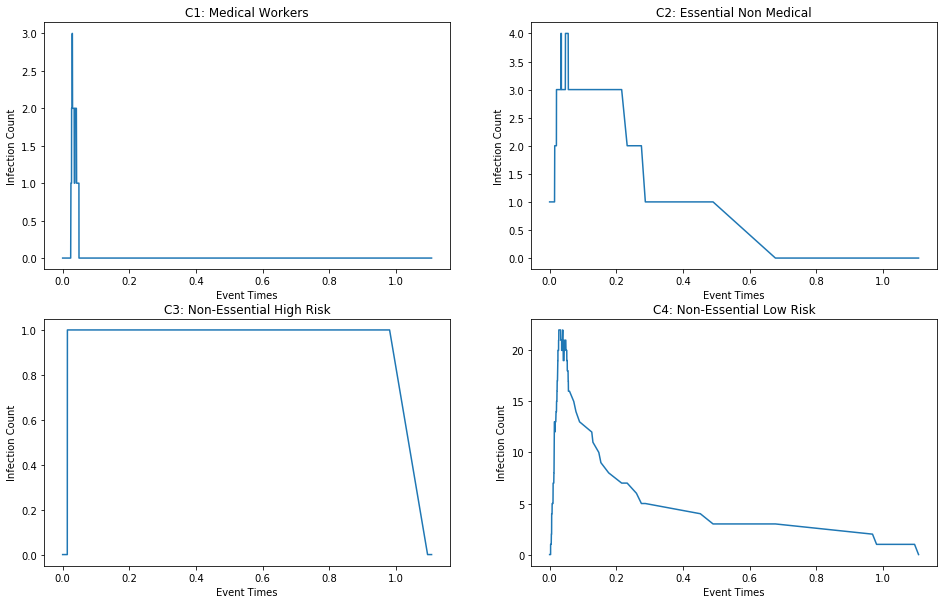

<Figure size 432x288 with 0 Axes>

In [447]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(16, 10))
# plot with various axes scales
plt.figure()

# C1
ax[0][0].plot(t, C1)
ax[0][0].set_title('C1: Medical Workers')
ax[0][0].set_xlabel('Event Times')
ax[0][0].set_ylabel('Infection Count')

# C2
ax[0][1].plot(t, C2)
ax[0][1].set_title('C2: Essential Non Medical')
ax[0][1].set_xlabel('Event Times')
ax[0][1].set_ylabel('Infection Count')

# C3
ax[1][0].plot(t, C3)
ax[1][0].set_title('C3: Non-Essential High Risk')
ax[1][0].set_xlabel('Event Times')
ax[1][0].set_ylabel('Infection Count')

# C4
ax[1][1].plot(t, C4)
ax[1][1].set_title('C4: Non-Essential Low Risk')
ax[1][1].set_xlabel('Event Times')
ax[1][1].set_ylabel('Infection Count')

plt.show()

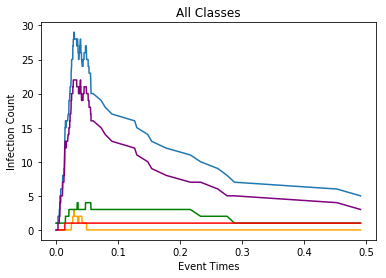

In [448]:
for i in range(0, len(t), 5):
  display.clear_output(wait=True)

  plt.plot(t[0:i], inf_tot[0:i])
  plt.plot(t[0:i], C1[0:i], color='orange')
  plt.plot(t[0:i], C2[0:i], color='green')
  plt.plot(t[0:i], C3[0:i], color='red')
  plt.plot(t[0:i], C4[0:i], color='purple')

  plt.title('All Classes')
  plt.xlabel('Event Times')
  plt.ylabel('Infection Count')

  plt.show()
  time.sleep(0)

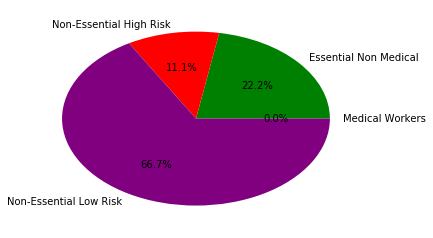

In [449]:
for i in range(0, len(t)-5, 5):
  display.clear_output(wait=True)

  labels = 'Medical Workers','Essential Non Medical', 'Non-Essential High Risk','Non-Essential Low Risk'
  sizes = [C1[i], C2[i], C3[i], C4[i]]
  colors = ['orange', 'green', 'red', 'purple']

  plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%')

  plt.show()
  time.sleep(0)

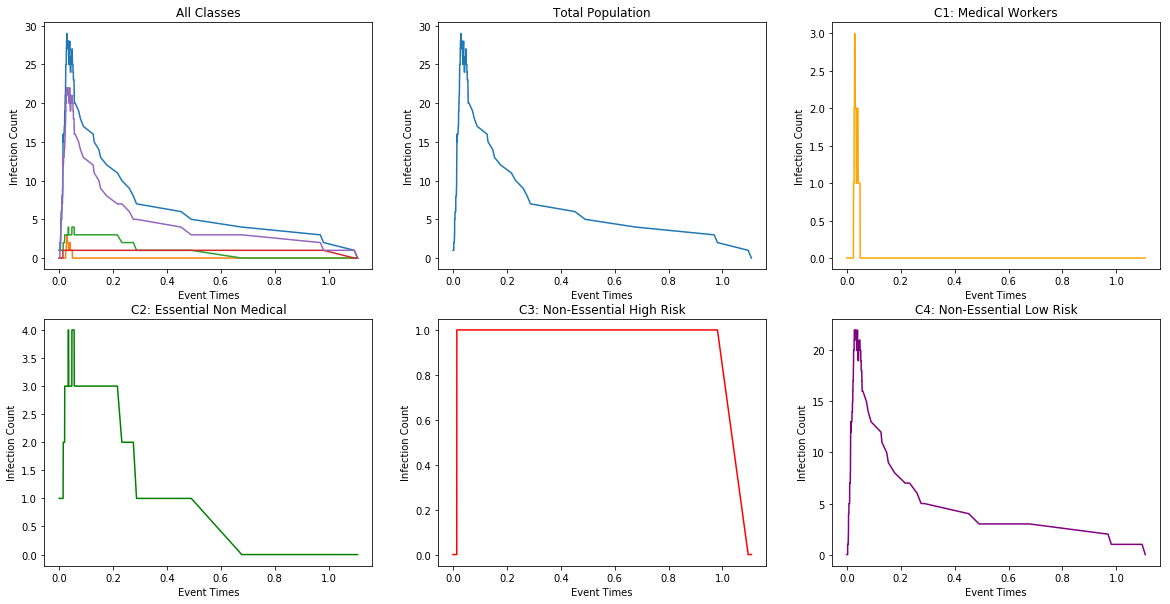

<Figure size 432x288 with 0 Axes>

In [450]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(20, 10))
plt.figure()

#Overlay plot
ax[0][0].plot(t, inf_tot)
ax[0][0].plot(t, C1)
ax[0][0].plot(t, C2)
ax[0][0].plot(t, C3)
ax[0][0].plot(t, C4)
ax[0][0].set_title('All Classes')
ax[0][0].set_xlabel('Event Times')
ax[0][0].set_ylabel('Infection Count')

#Total
ax[0][1].plot(t, inf_tot)
ax[0][1].set_title('Total Population')
ax[0][1].set_xlabel('Event Times')
ax[0][1].set_ylabel('Infection Count')

#C1
ax[0][2].plot(t, C1, color='orange')
ax[0][2].set_title('C1: Medical Workers')
ax[0][2].set_xlabel('Event Times')
ax[0][2].set_ylabel('Infection Count')

#C2
ax[1][0].plot(t, C2, color='green')
ax[1][0].set_title('C2: Essential Non Medical')
ax[1][0].set_xlabel('Event Times')
ax[1][0].set_ylabel('Infection Count')

#C3
ax[1][1].plot(t, C3, color='red')
ax[1][1].set_title('C3: Non-Essential High Risk')
ax[1][1].set_xlabel('Event Times')
ax[1][1].set_ylabel('Infection Count')

#C4
ax[1][2].plot(t, C4, color='purple')
ax[1][2].set_title('C4: Non-Essential Low Risk')
ax[1][2].set_xlabel('Event Times')
ax[1][2].set_ylabel('Infection Count')

plt.show()